# Starbucks Promotion Classification

In [ ]:
# 20241202 EDA 초안
# 20241204 전처리 보완
# 20241205 customer_based_df 에서 집계할 때 offer_type 집계하는 건 의미상 맞지 않아서 삭제
           # total amount 추가
           # portpolio - channel 컬럼 인코딩 추가

    # Q. portfolio_df 에 있는 10개 행을 각각 한 개 타입이라고 말하고 해석할 수 있는지?
    # 해석 상으로는 email, sns 등등.. 채널을 모두 풀어서 분리해서 보거나 or bogo, ... 의 타입 중으로 말하는 게 현실적인 스토리일 듯 함.
    # 액션을 맞추는 것 (offer_completed) 까지만 해석에 포함?
    # -> channel 컬럼도 따로 개별 컬럼 범주형 인코딩 빼는 거 추가

# 1. 모듈 불러오기

In [ ]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from datetime import datetime
from dateutil import parser
import numpy as np
import ast

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# 2. 데이터 읽어오기

In [ ]:
CWD = os.getcwd()
STARBUCKS_PATH = "./dataset/"

print("현재 경로: ", CWD)

def load_data(data_path, file):
    path = os.path.join(data_path, file)
    return pd.read_csv(path, index_col=0)

portfolio_df = load_data(STARBUCKS_PATH,'portfolio_df.csv' )
profile_df = load_data(STARBUCKS_PATH, 'profile_df.csv')
transcript_df = load_data(STARBUCKS_PATH, 'transcript_df.csv')

현재 경로:  c:\Users\miseu\SpartaClub\02_데이터분석\ML\project


# 3. 데이터 탐색

## 3-1. EDA

### portfolio

In [ ]:
# 데이터 기본 정보를 먼저 확인함 (head, info, size, shape, null, duplicated, descriptive)

def basic_eda(df):

    import pandas as pd

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    print(f"\n================== Basic Information ==================")

    # 데이터 상단부 확인
    print("\n------------ Head ------------")
    print(df.head())

    # 데이터 정보 및 크기 확인
    print("\n------------ Information ------------")
    print(df.info())
    print(f"\nSize: {df.size}")
    print(f"Shape: {df.shape}")

    # 결측치 확인
    print("\n------------ Missing Values ------------")
    print(df.isnull().sum())

    # 중복값 확인
    print("\n------------ Duplicate Values ------------")
    print(df.duplicated().value_counts())

    # 데이터 기술통계량 확인 (int, float type)
    print("\n------------ Descriptive Statistics (Numeric) ------------")
    print(df.describe())

    # 데이터 기술통계량 확인 (object type)
    print("\n------------ Descriptive Statistics (Categorical) ------------")

    try:
        print(df.describe(include=[object]))

    except:
        object_cols = df.select_dtypes(include=['object']).columns
        error_cols = []

        for col in object_cols:
            if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
                error_cols.append(col)
        print(f"{error_cols} Excluded")
        print(df.loc[:, ~df.columns.isin(error_cols)].describe(include=[object]))

    print("=" * 60)

In [ ]:
basic_eda(portfolio_df)


================== Basic Information ==================

------------ Head ------------
   reward                              channels  difficulty  duration  \
0      10         ['email', 'mobile', 'social']          10       7.0   
1      10  ['web', 'email', 'mobile', 'social']          10       5.0   
2       0            ['web', 'email', 'mobile']           0       4.0   
3       5            ['web', 'email', 'mobile']           5       7.0   
4       5                      ['web', 'email']          20      10.0   

      offer_type                                id  
0           bogo  ae264e3637204a6fb9bb56bc8210ddfd  
1           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  informational  3f207df678b143eea3cee63160fa8bed  
3           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7  

------------ Information ------------
<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      No

In [ ]:
# 추가로 확인하고 싶은 내용들을 출력해봄 : 채널 안에 unique 값, 오퍼 타입의 unique 값
print(portfolio_df.channels.unique())
print(portfolio_df.offer_type.unique())

["['email', 'mobile', 'social']" "['web', 'email', 'mobile', 'social']"
 "['web', 'email', 'mobile']" "['web', 'email']"]
['bogo' 'informational' 'discount']


> 확인한 정보
- 6개의 컬럼 (reward, channels, difficulty, duration, offer_type, id) 로 구성됨.
- 데이터는 10행, 6열 (10,6) 의 크기임.
- 결측치, 중복값 없음
- numerical variable : reward (int), difficulty (int), duration (float)
  - duration : 프로모션 활성화 기간 (일 단위) 라고 함.
- categorical variable : channels (object), offer_type (object), id (object)
  - channels : email, mobile, social, web
  - offer_type : bogo, informational, discount


### profile

In [ ]:
basic_eda(profile_df)


================== Basic Information ==================

------------ Head ------------
  gender  age                                id  became_member_on    income
0    NaN  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2    NaN  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4    NaN  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

------------ Information ------------
<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 no

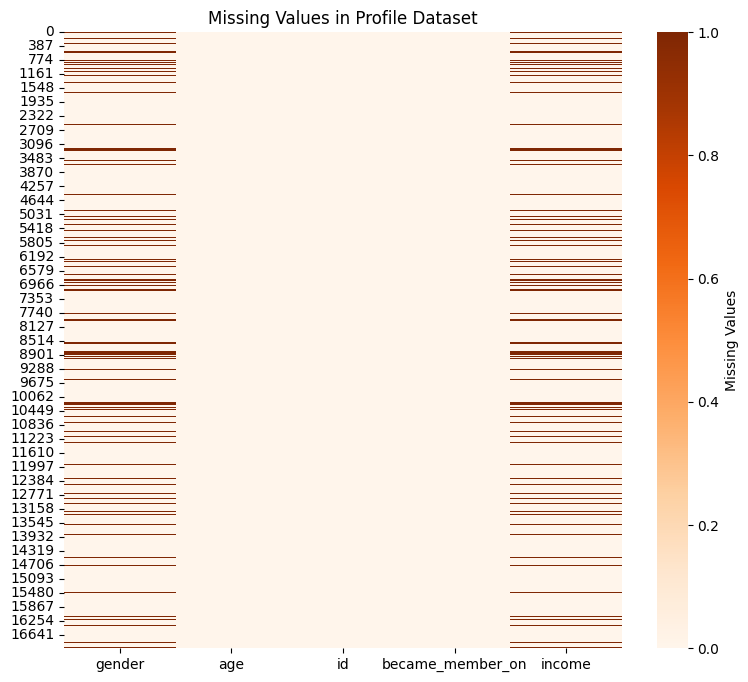

In [ ]:
# 위 기초 정보 확인에서 null 값이 확인됨 -> 시각화로 확인 후, 삭제 -> 삭제 적용 시각화
profile_df.isnull().sum()

# profile_df 에 결측치 시각화
plt.close()
plt.figure(figsize=(9,8))
sns.heatmap(profile_df.isnull(), cbar_kws={'label':'Missing Values'}, cmap='Oranges')
plt.title('Missing Values in Profile Dataset')
plt.show()

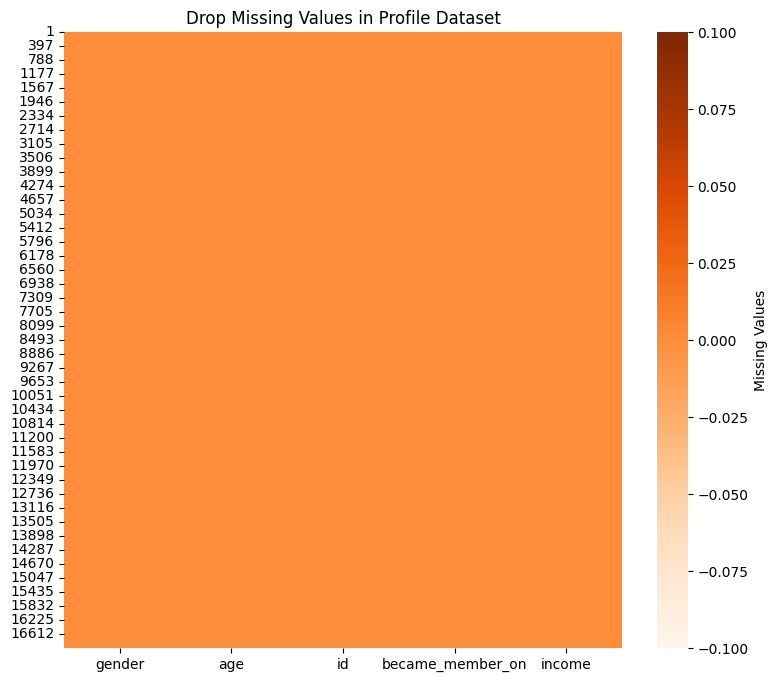

In [ ]:
# 결측치 행 삭제
profile_df.dropna(inplace=True)
profile_df.isnull().sum()

# 결측치 삭제 확인 시각화 -> 모두균일한 색으로 나오면 없는 것 !
plt.close()
plt.figure(figsize=(9,8))
sns.heatmap(profile_df.isnull(), cbar_kws={'label':'Missing Values'}, cmap='Oranges')
plt.title('Drop Missing Values in Profile Dataset')
plt.show()

In [ ]:
# 기초 정보 EDA 외에 궁금한 열 등 확인
print(profile_df.gender.unique())
print(len(profile_df.id.unique()))

['F' 'M' 'O']
14825


In [ ]:
# profile 데이터 안에 날짜 컬럼 타입 수정
profile_df['became_member_on_dt'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')
# 가장 마지막 고객 가입일자의 다음달 1일 기준으로 고객들의 가입한 기간을 확인함. (일 단위)
ref_date = datetime.strptime('2018-08-01 00:00:00', "%Y-%m-%d %H:%M:%S")
profile_df['days_membered'] = (ref_date - profile_df['became_member_on_dt']).dt.days
profile_df.head(3)

,gender,age,id,became_member_on,income,became_member_on_dt,days_membered
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,382
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,449
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,97


> 확인한 정보
- 5개의 컬럼 ('gender', 'age', 'id', 'became_member_on', 'income') 로 구성됨.
- 데이터는 17000행, 5열 (17000,5) 의 크기임.
- 결측치 gender, income에서 2175건 씩 있음.
  - 현재 결측치 '행' 기준 삭제함.
  - 삭제할 경우, 데이터 크기 (14825, 5)
- 중복값 없음
- numerical variable : age (int), became_member_on (int), income (float)
  - income : 고객의 연소득
  - became_member_on : 날짜 형태로 전처리 함 (동일컬럼명_dt)
    - 오늘 날짜 기준으로 빼서, 얼마나 오래된 고객인지 컬럼 새로 만들어두는 것도 괜찮을 것 같음
- categorical variable : gender (object), id (object)
  - gender : M (Male), F (Female), O (Other)

### transcript

In [ ]:
basic_eda(transcript_df)


================== Basic Information ==================

------------ Head ------------
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  

------------ Information ------------
<class 'pandas.core.frame.DataFrame'>
Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0

In [ ]:
# 타겟 변수로 고려할 수 있을 것으로 보이는 event 컬럼 구성 확인해봄
print(transcript_df.event.unique())
print(len(transcript_df.person.unique())) # 고객 수 확인

['offer received' 'offer viewed' 'transaction' 'offer completed']
17000


> 확인한 정보
- 4개의 컬럼 ('person', 'event', 'value', 'time') 로 구성됨.
- 데이터는 306534행, 4열 (306534, 4) 의 크기임.
- 결측치, 중복값 없음
- numerical variable : time (int)
- categorical variable : person (object), event (object), value (object)
  - value : 프로모션 ID, amount, reward ..

In [ ]:
# 필요 시 출력 옵션 초기화
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

## 3-2. 데이터 전처리

### Key Normalization
- 키 정규화 부분은 캐글 targeted-marketing-strategy-for-starbucks 스크립트 참고해서 작성하였습니다.

##### KEY 1. CUSTOMER ID

In [ ]:
CUSTOMER_IDS = pd.unique(transcript_df['person'])

# 일련번호 문자열 형태 -> 숫자 0,1,2,3 으로 맵핑하여 바꿔주는 작업
CUSTOMER_IDS_dict = pd.Series(CUSTOMER_IDS).to_dict()
CUSTOMER_IDS_dict = dict([(value, key) for key, value in CUSTOMER_IDS_dict.items()])
itr = iter(CUSTOMER_IDS_dict.items())
lst = [next(itr) for i in range(10)]
print(lst)

[('78afa995795e4d85b5d9ceeca43f5fef', 0), ('a03223e636434f42ac4c3df47e8bac43', 1), ('e2127556f4f64592b11af22de27a7932', 2), ('8ec6ce2a7e7949b1bf142def7d0e0586', 3), ('68617ca6246f4fbc85e91a2a49552598', 4), ('389bc3fa690240e798340f5a15918d5c', 5), ('c4863c7985cf408faee930f111475da3', 6), ('2eeac8d8feae4a8cad5a6af0499a211d', 7), ('aa4862eba776480b8bb9c68455b8c2e1', 8), ('31dda685af34476cad5bc968bdb01c53', 9)]


In [ ]:
# 위에서 만들어둔 CUSTOMER_IDS_dict를 기준으로: transcript, profile 에 있는 기존 id 값들과 맵핑하여줌
transcript_df['CUSTOMER_ID'] = transcript_df['person'].map(CUSTOMER_IDS_dict)
profile_df['CUSTOMER_ID'] = profile_df['id'].map(CUSTOMER_IDS_dict)

transcript_df.sort_values('CUSTOMER_ID', axis=0, ascending=True, inplace=True, kind='quicksort')
transcript_df.reset_index(inplace=True, drop=True)

profile_df.sort_values('CUSTOMER_ID', axis=0, ascending=True, inplace=True, kind='quicksort')
profile_df.reset_index(inplace=True, drop=True)

transcript_df.head(3)

,person,event,value,time,CUSTOMER_ID
0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0
1,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,0


##### KEY 2. OFFER ID

In [ ]:
OFFER_IDS = pd.unique(portfolio_df['id'])

OFFER_IDS_dict = pd.Series(OFFER_IDS).to_dict()
OFFER_IDS_dict = dict([(value, key) for key, value in OFFER_IDS_dict.items()])
itr = iter(OFFER_IDS_dict.items())
lst = [next(itr) for i in range(10)]
print(lst)

[('ae264e3637204a6fb9bb56bc8210ddfd', 0), ('4d5c57ea9a6940dd891ad53e9dbe8da0', 1), ('3f207df678b143eea3cee63160fa8bed', 2), ('9b98b8c7a33c4b65b9aebfe6a799e6d9', 3), ('0b1e1539f2cc45b7b9fa7c272da2e1d7', 4), ('2298d6c36e964ae4a3e7e9706d1fb8c2', 5), ('fafdcd668e3743c1bb461111dcafc2a4', 6), ('5a8bc65990b245e5a138643cd4eb9837', 7), ('f19421c1d4aa40978ebb69ca19b0e20d', 8), ('2906b810c7d4411798c6938adc9daaa5', 9)]


In [ ]:
# transcript value 컬럼 내 값 추출 후 별도 컬럼 생성
transcript_df['value'] = transcript_df['value'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # 딕셔너리 형태로 변환
transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer_id') or x.get('offer id', np.nan)) # value 값 내 offer id와 offer_id 두 가지 값 추출
transcript_df['reward'] = transcript_df['value'].apply(lambda x: x.get('reward', np.nan)) # value 값 내 reward 값 추출, 없으면 nan
transcript_df['amount'] = transcript_df['value'].apply(lambda x: x.get('amount'), np.nan) #amount 값 추출, 없으면 nan

C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\4227843388.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  transcript_df['amount'] = transcript_df['value'].apply(lambda x: x.get('amount'), np.nan) #amount 값 추출, 없으면 nan


In [ ]:
transcript_df['OFFER_ID'] = transcript_df['offer_id'].map(OFFER_IDS_dict)
portfolio_df['OFFER_ID'] = portfolio_df['id'].map(OFFER_IDS_dict)

transcript_df.reset_index(inplace=True, drop=True)
portfolio_df.reset_index(inplace=True, drop=True)

transcript_df.head(3)

,person,event,value,time,CUSTOMER_ID,offer_id,reward,amount,OFFER_ID
0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,3.0
1,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,0,NaN,NaN,23.93,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,0,NaN,NaN,19.67,NaN


### 파생변수 추가 및 데이터 병합

In [ ]:
# 범주형 변수 더미 코딩
def dummy_encode(x):

    dummies = pd.get_dummies(x, dummy_na=True, dtype=int)

    return dummies

# 3개 데이터에 필요한 범주형 변수들 인코딩 적용
transcript_df = transcript_df.merge(dummy_encode(transcript_df['event']), left_index=True, right_index=True)
profile_df = profile_df.merge(dummy_encode(profile_df['gender']), left_index=True, right_index=True)
portfolio_df = portfolio_df.merge(dummy_encode(portfolio_df['offer_type']), left_index=True, right_index=True)

In [ ]:
# str 안에 list 타입인 portfolio - channel 컬럼은 별도 적용 (캐글 참고했어요 !)
def one_hot_channels(df):

    channels_list = ['web', 'email', 'mobile', 'social']
    df['web_channel'] = df['channels'].apply(lambda x: 1 if channels_list[0] in x else 0)
    df['email_channel'] = df['channels'].apply(lambda x: 1 if channels_list[1] in x else 0)
    df['mobile_channel'] = df['channels'].apply(lambda x: 1 if channels_list[2] in x else 0)
    df['social_channel'] = df['channels'].apply(lambda x: 1 if channels_list[3] in x else 0)

one_hot_channels(portfolio_df)

#### 베이스 데이터

In [ ]:
# portfolio_df & transcript_df -> merge
port_trans_df = pd.merge(portfolio_df, transcript_df, how='outer', on='OFFER_ID')
print("port_trans_df & transcript_df Merged Shape: ", port_trans_df.shape)

port_trans_df & transcript_df Merged Shape:  (306534, 28)


In [ ]:
# 고객 ID를 기준으로 추가 집계할 수 있는 컬럼들 생성
customer_based_df = transcript_df.groupby(['CUSTOMER_ID', 'event'])['OFFER_ID'].apply(list).unstack(fill_value='No data').reset_index() # Q. 이 열 실제 모델에서 사용했는지..? 고객 별로 10가지 타입 매칭 ? 분류 ? 도?

# 0: event 타입 상관없이 고객 별 모든 event 의 횟수 카운트
customer_ids_frequency = transcript_df['CUSTOMER_ID'].value_counts(sort=False)
customer_based_df['customer_frequency'] = transcript_df['CUSTOMER_ID'].value_counts(sort=False)

# 1: 고객 별 event 카운트
customer_event_cnt = port_trans_df.groupby('CUSTOMER_ID')['event'].value_counts().unstack(fill_value=np.nan)
customer_event_cnt.columns = [f"event_{col}_cnt" for col in customer_event_cnt.columns]
customer_based_df = pd.merge(customer_based_df, customer_event_cnt, on='CUSTOMER_ID', how='left')

# 2: 고객 별 OFFER_ID 카운트 (portfolio에 있는 10개)
customer_offerid_cnt = port_trans_df.groupby('CUSTOMER_ID')['OFFER_ID'].value_counts().unstack(fill_value=np.nan)
customer_offerid_cnt.columns = [f"OFFER_ID_{int(col)}_cnt" for col in customer_offerid_cnt.columns]
customer_based_df = pd.merge(customer_based_df, customer_offerid_cnt, on='CUSTOMER_ID', how='left')

# 3: 고객 별 reward 평균 (transcript 기준 실제 받은 reward)
reward_avg = port_trans_df.groupby('CUSTOMER_ID')['reward_y'].mean().reset_index()
reward_avg.rename(columns={'reward_y': 'reward_avg'}, inplace=True)
customer_based_df = pd.merge(customer_based_df, reward_avg, on='CUSTOMER_ID', how='left')

# 4: 고객 별 amount 평균
amount_avg = port_trans_df.groupby('CUSTOMER_ID')['amount'].mean().reset_index()
amount_avg.rename(columns={'amount': 'amount_avg'}, inplace=True)
customer_based_df = pd.merge(customer_based_df, amount_avg, on='CUSTOMER_ID', how='left')

# 5: 고객 별 총 amount 합계
total_amount = port_trans_df.groupby('CUSTOMER_ID')['amount'].sum().reset_index()
total_amount.rename(columns={'amount': 'amount_avg'}, inplace=True)
customer_based_df = pd.merge(customer_based_df, total_amount, on='CUSTOMER_ID', how='left')

# 6: 고객 별 difficulty 평균 (고객 별 수행한 이벤트 상태 (offer viewed, offer completed ..) 에 따라 프로모션 난이도의 평균)
difficulty_avg = pd.pivot_table(port_trans_df, values='difficulty', index='CUSTOMER_ID', columns='event', aggfunc='mean').reset_index()
difficulty_avg.columns = [f"difficulty_{col}" if col != "CUSTOMER_ID" else col for col in difficulty_avg.columns]
customer_based_df = pd.merge(customer_based_df, difficulty_avg, on='CUSTOMER_ID', how='left')

print(customer_based_df.info())
print(customer_based_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CUSTOMER_ID                 17000 non-null  int64  
 1   offer completed             17000 non-null  object 
 2   offer received              17000 non-null  object 
 3   offer viewed                17000 non-null  object 
 4   transaction                 17000 non-null  object 
 5   customer_frequency          17000 non-null  int64  
 6   event_offer completed_cnt   12774 non-null  float64
 7   event_offer received_cnt    16994 non-null  float64
 8   event_offer viewed_cnt      16834 non-null  float64
 9   event_transaction_cnt       16578 non-null  float64
 10  OFFER_ID_0_cnt              6374 non-null   float64
 11  OFFER_ID_1_cnt              6330 non-null   float64
 12  OFFER_ID_2_cnt              6331 non-null   float64
 13  OFFER_ID_3_cnt              635

In [ ]:
# 고객의 참여도 컬럼 정의 추가
def ast_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

for col in ['offer received', 'offer viewed', 'offer completed']:
    customer_based_df[col] = customer_based_df[col].apply(lambda x: ast_literal_eval(x) if isinstance(x, str) else x)

for code in range(10):
    customer_based_df[f'promotion_code_{code}'] = customer_based_df.apply(
        lambda row: (
            # 3: 프로모션을 완료한 경우
            3 if (code in row['offer completed']) else
            # 2: 프로모션을 받았고, 본 경우
            2 if (code in row['offer received']) & (code in row['offer viewed']) else
            # 1: 프로모션을 받기만 한 경우
            1 if (code in row['offer received'])
            # 0: 프로모션과 관련이 없는 경우
            else 0
        ), axis=1) # Q. 시간을 고려 안하고, 고객 기준으로 합친 후에 한 거면 -> 시간 기준으로 컬럼 정의 새로 추가 가능할 거 같음

In [ ]:
customer_based_df = customer_based_df.merge(profile_df, on="CUSTOMER_ID", how="left") # 버전 3. 지금 쓰고 있는 거..

customer_based_df.drop(customer_based_df.columns[-1], axis=1, inplace=True) # nan 으로 찍힌 마지막 열 삭제
customer_based_df.dropna(subset=['gender','age'], inplace=True) # gender, age 기준 결측치 삭제
customer_based_df = customer_based_df.fillna(0).reset_index()

customer_based_df.isnull().sum() # 만약에 밑에 tmp_ 를 쓴다면 여기서 프로필이랑 머지할 필요 없음. 위에까지만 하고 -> 맨 아래 tmp 생성하면 됨.

index                         0
CUSTOMER_ID                   0
offer completed               0
offer received                0
offer viewed                  0
transaction                   0
customer_frequency            0
event_offer completed_cnt     0
event_offer received_cnt      0
event_offer viewed_cnt        0
event_transaction_cnt         0
OFFER_ID_0_cnt                0
OFFER_ID_1_cnt                0
OFFER_ID_2_cnt                0
OFFER_ID_3_cnt                0
OFFER_ID_4_cnt                0
OFFER_ID_5_cnt                0
OFFER_ID_6_cnt                0
OFFER_ID_7_cnt                0
OFFER_ID_8_cnt                0
OFFER_ID_9_cnt                0
reward_avg                    0
amount_avg_x                  0
amount_avg_y                  0
difficulty_offer completed    0
difficulty_offer received     0
difficulty_offer viewed       0
promotion_code_0              0
promotion_code_1              0
promotion_code_2              0
promotion_code_3              0
promotio

In [ ]:
# 위에꺼는 지금 고객 기준 집계한 거에 profile 만 합친 거고
# null 값이 많이 생기기는 하지만 아래처럼 해야 3개 데이터를 다 합친 거

In [ ]:
# 버전 2. 기본 3개 데이터를 쭉 합친 거
merged_df = transcript_df.merge(

    profile_df,
    on="CUSTOMER_ID",
    how="left"

    ).merge(

        portfolio_df,
        on="OFFER_ID",
        how="left"
    )

merged_df.head(3)

,person,event,value,time,CUSTOMER_ID,offer_id,reward_x,amount,OFFER_ID,offer completed,...,offer_type,id_y,bogo,discount,informational,NaN,web_channel,email_channel,mobile_channel,social_channel
0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,3.0,0,...,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,0,NaN,NaN,23.93,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,0,NaN,NaN,19.67,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
drop_col = ['person','value', 'nan_x', 'offer_id', 'id_x', 'nan_y', 'id_y']
merged_df.drop(drop_col, axis=1, inplace=True)
merged_df.drop(merged_df.columns[-1], axis=1, inplace=True)
merged_df.drop(merged_df.columns[27], axis=1, inplace=True) # NaN 삭제 안된 게 있었음

merged_df.rename(columns={'reward_x':'reward_actual','reward_y':'reward_base'}, inplace=True)
merged_df.dropna(subset=['gender','age'], inplace=True)

zero_fill_col = ['reward_actual','amount']
for col in zero_fill_col:
    merged_df[col] = merged_df[col].fillna(0)

merged_df.isnull().sum()

event                       0
time                        0
CUSTOMER_ID                 0
reward_actual               0
amount                      0
OFFER_ID               123957
offer completed             0
offer received              0
offer viewed                0
transaction                 0
gender                      0
age                         0
became_member_on            0
income                      0
became_member_on_dt         0
days_membered               0
F                           0
M                           0
O                           0
reward_base            123957
channels               123957
difficulty             123957
duration               123957
offer_type             123957
bogo                   123957
discount               123957
informational          123957
web_channel            123957
email_channel          123957
mobile_channel         123957
dtype: int64

## 3-3. 시각화

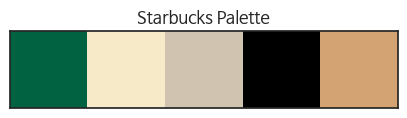

In [ ]:
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
plt.rc("axes", unicode_minus=False)  # 음수 부호 깨짐 방지

sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style="white")

# 그래프 색상 팔레트
starbucks_palette = sns.color_palette(["#006241", "#f7eac8", "#d0c4b0", "#000000", "#d4a373"])
starbucks_pal_dark = sns.color_palette(["#006241", "#d4a373", "#000000"])

# sequential 데이터용 팔레트
green_palette = sns.light_palette("#006241", n_colors=15)

sns.palplot(starbucks_palette)
plt.title("Starbucks Palette")
plt.show()

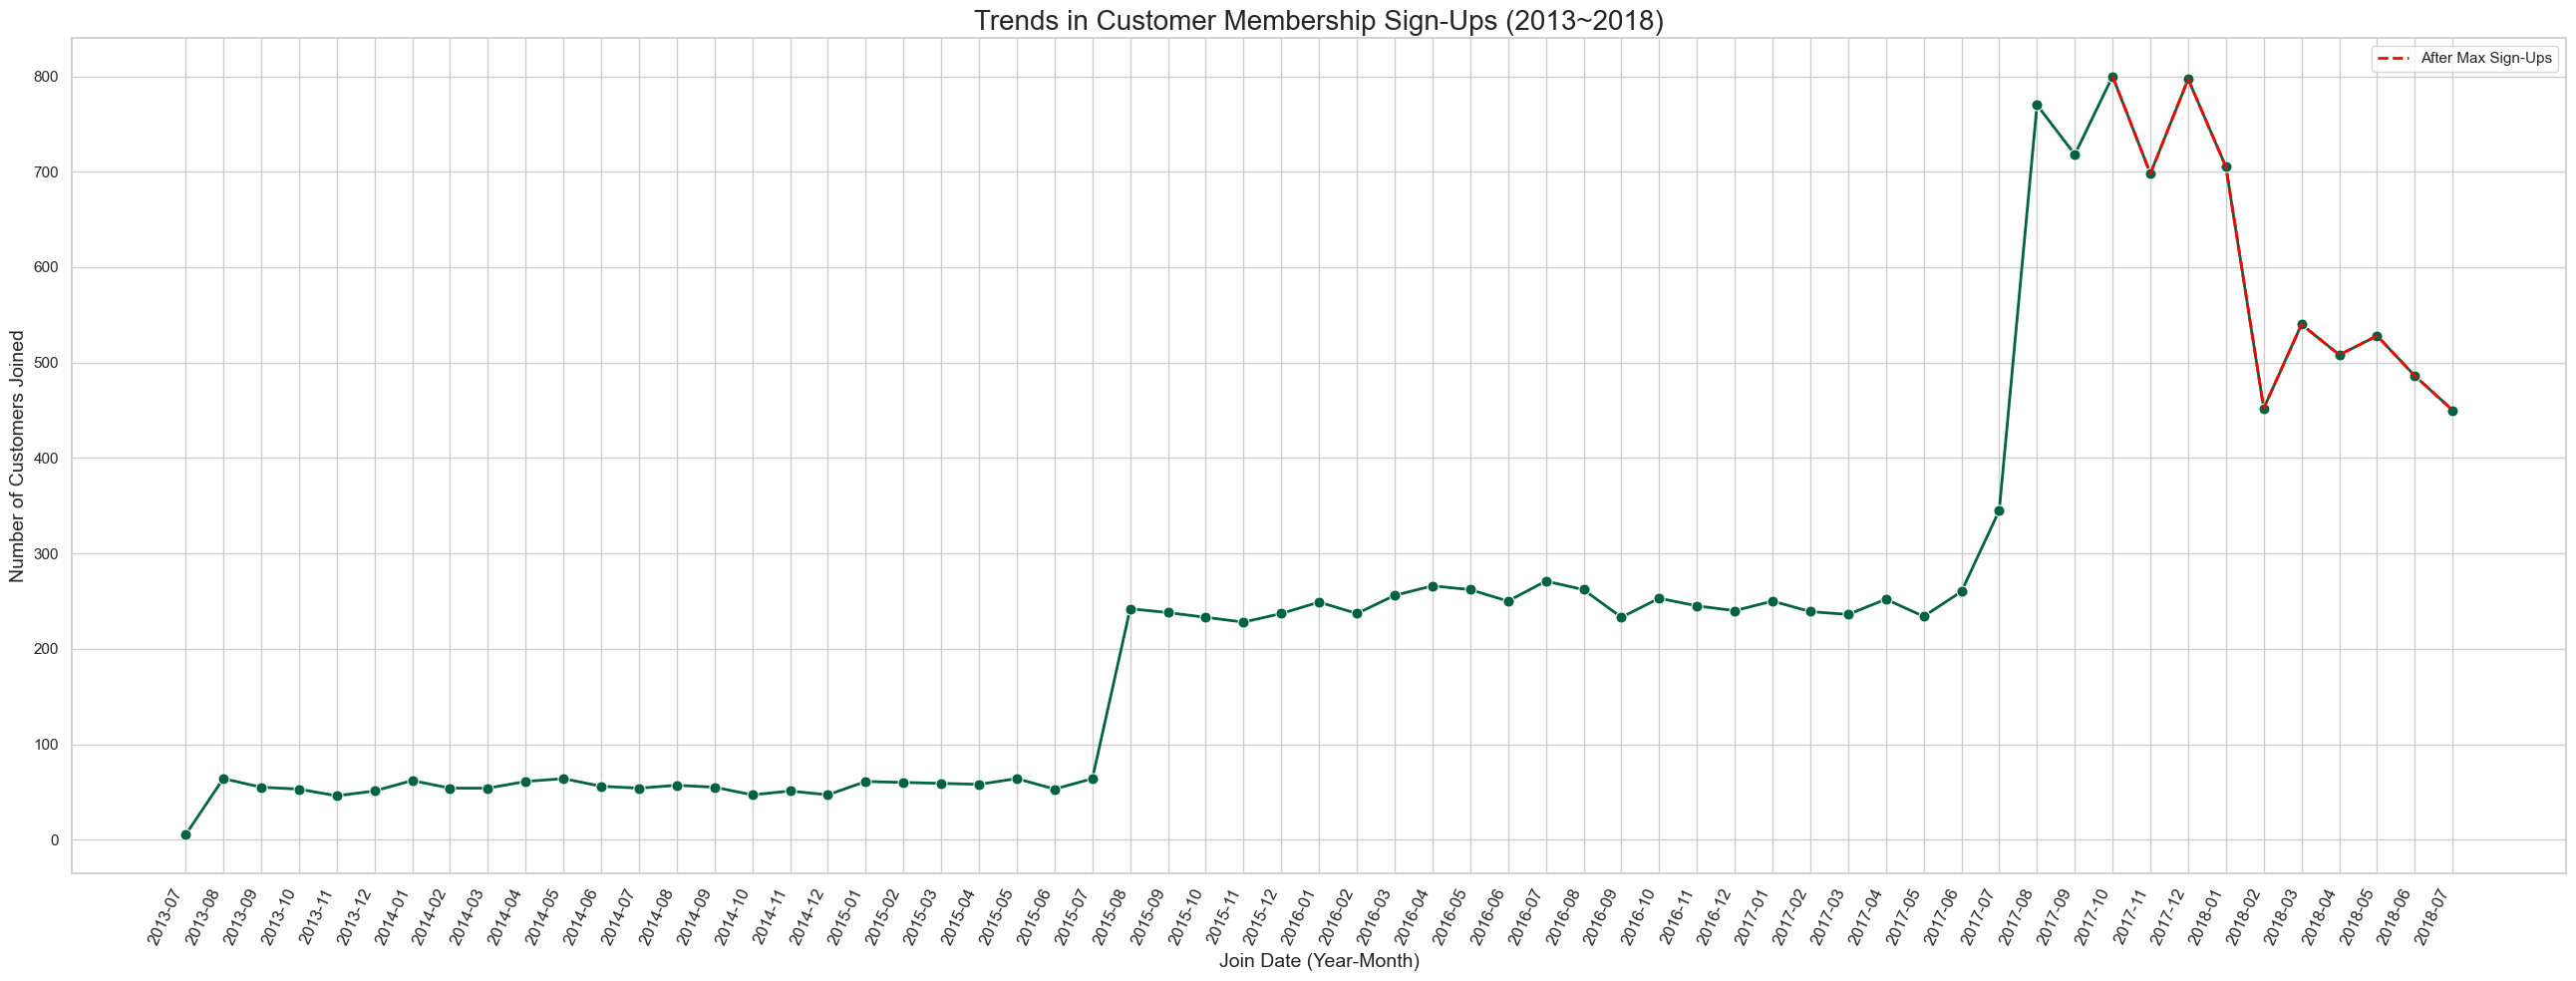

In [ ]:
# 연도별 가입 추이
df = profile_df
membership_dates = pd.to_datetime(df['became_member_on_dt']).dt.to_period('M')
membership_counts = membership_dates.value_counts().sort_index()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(26, 10))
sns.lineplot(x=membership_counts.index.astype(str), y=membership_counts.values, color="#006241", linewidth=2, marker="o", markersize=8)

max_index = membership_counts.idxmax()
highlight_start = membership_counts.index.get_loc(max_index)

sns.lineplot(x=membership_counts.index[highlight_start:].astype(str), y=membership_counts.values[highlight_start:], color="red", linewidth=2, linestyle="--", label='After Max Sign-Ups')

plt.title('Trends in Customer Membership Sign-Ups (2013~2018)', fontsize=20)
plt.xticks(rotation=65, ha='right', fontsize=12)

plt.xlabel('Join Date (Year-Month)', fontsize=14)
plt.ylabel('Number of Customers Joined', fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\2093494815.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, ax=axes[2], palette=starbucks_pal_dark)


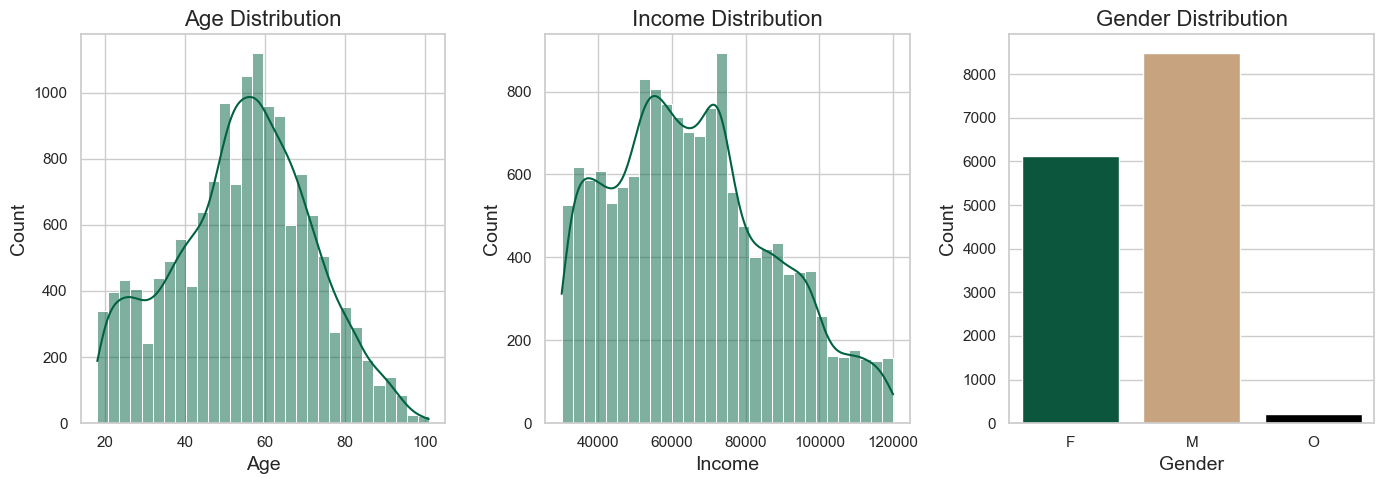

In [ ]:
# 고객 정보 데이터 기본 분포 시각화
df = profile_df
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Age distribution
sns.histplot(df['age'].dropna(), bins=30, ax=axes[0], kde=True, color="#006241")
axes[0].set_title('Age Distribution', fontsize=16)
axes[0].set_xlabel('Age', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)

# Income distribution
sns.histplot(df['income'].dropna(), bins=30, ax=axes[1], kde=True, color="#006241")
axes[1].set_title('Income Distribution', fontsize=16)
axes[1].set_xlabel('Income', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)

# Gender distribution
sns.countplot(x='gender', data=df, ax=axes[2], palette=starbucks_pal_dark)
axes[2].set_title('Gender Distribution', fontsize=16)
axes[2].set_xlabel('Gender', fontsize=14)
axes[2].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

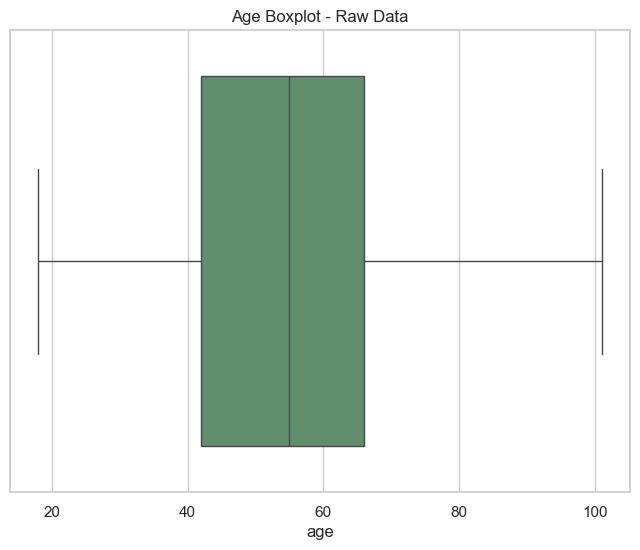

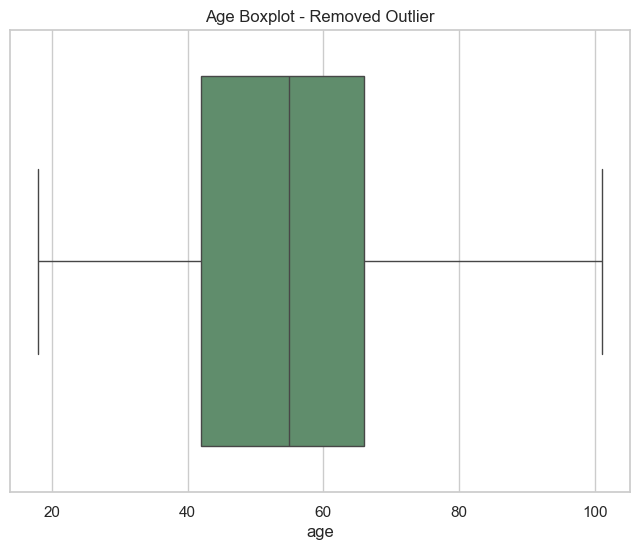

In [ ]:
# 연령에 이상치 확인 및 제거
df = profile_df # 위에서 이미 결측치 제거했으면 박스 플롯 똑같이 찍히는 게 맞아요 !

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['age'], color="#599468")
plt.title('Age Boxplot - Raw Data')
plt.show()

# 이상치 기준 계산
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1  # IQR: 3사분위수 - 1사분위수

lower_criteria = Q1 - 1.5 * IQR
upper_criteria = Q3 + 1.5 * IQR

# 이상치 제거
df_cleaned = df[(df['age'] >= lower_criteria) & (df['age'] <= upper_criteria)]

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['age'], color="#599468")
plt.title('Age Boxplot - Removed Outlier')
plt.show()

C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\3162515486.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='reward', data=df, ax=axes[0, 0], palette=green_palette[10:])
C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\3162515486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='difficulty', data=df, ax=axes[0, 1], palette=green_palette[10:])
C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\3162515486.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='offer_type', data=df, ax=axes[1, 1], palette=starbucks_pal_dark)


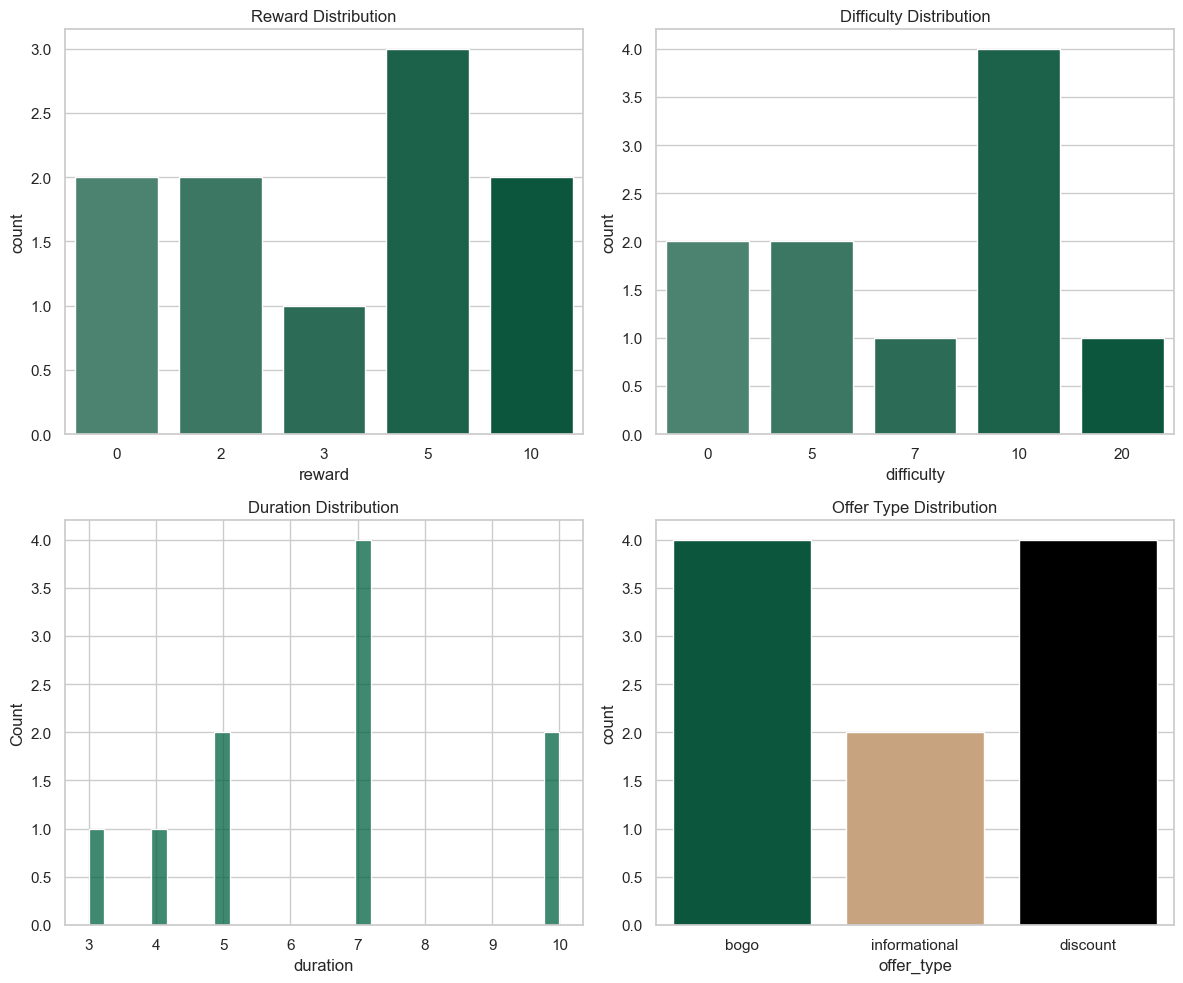

In [ ]:
# 프로모션 이벤트 정보
df = portfolio_df

# Define subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Reward distribution
sns.countplot(x='reward', data=df, ax=axes[0, 0], palette=green_palette[10:])
axes[0, 0].set_title('Reward Distribution')

# Difficulty distribution
sns.countplot(x='difficulty', data=df, ax=axes[0, 1], palette=green_palette[10:])
axes[0, 1].set_title('Difficulty Distribution')

# Duration distribution
sns.histplot(df['duration'], bins=30, ax=axes[1, 0], color="#006241")
axes[1, 0].set_title('Duration Distribution')

# Offer Type distribution
sns.countplot(x='offer_type', data=df, ax=axes[1, 1], palette=starbucks_pal_dark)
axes[1, 1].set_title('Offer Type Distribution')

plt.tight_layout()
plt.show()

C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\1129957493.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='event', data=df, ax=axes[0], palette=starbucks_palette[::-1])
C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\1129957493.py:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.countplot(x='event', data=df, ax=axes[0], palette=starbucks_palette[::-1])
C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\1129957493.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='reward', data=df, ax=axes[2], palette=green_palette[6:])
C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\1129957493.py:19: UserWarning: The palette list ha

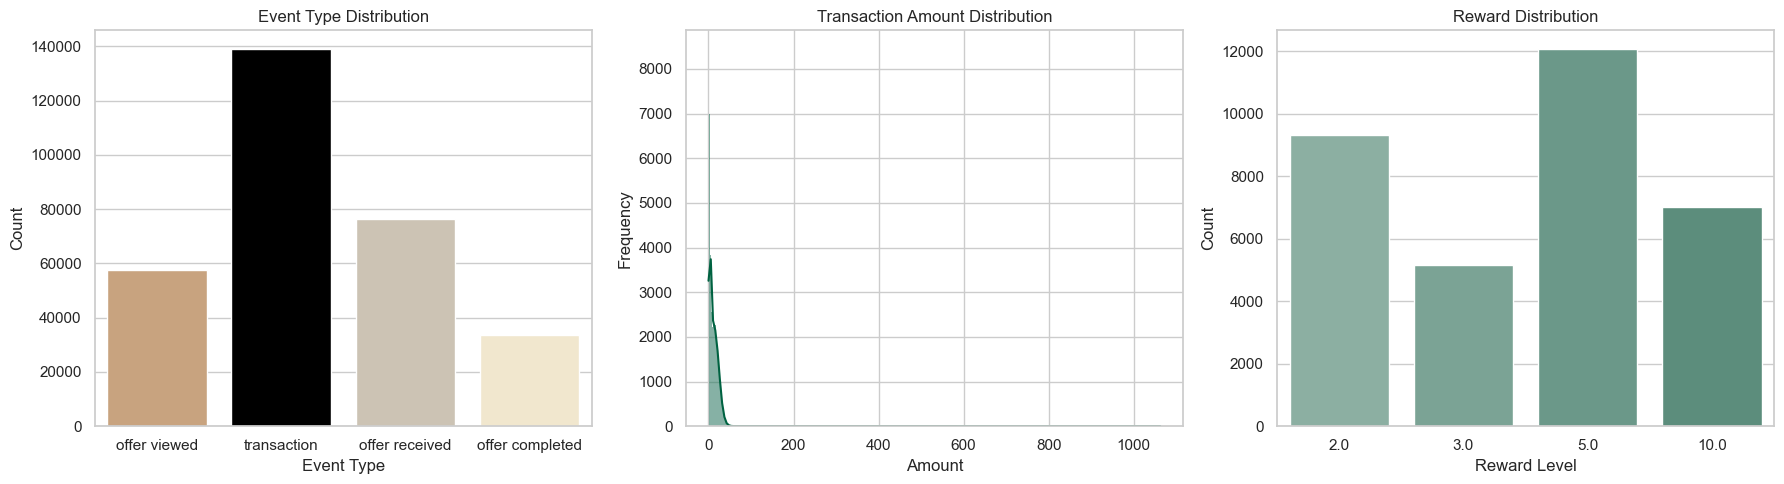

In [ ]:
df = transcript_df

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 이벤트 유형 분포
sns.countplot(x='event', data=df, ax=axes[0], palette=starbucks_palette[::-1])
axes[0].set_title('Event Type Distribution')
axes[0].set_xlabel('Event Type')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylabel('Count')

# 거래 금액 분포 (히스토그램)
sns.histplot(x='amount', data=df, kde=True, ax=axes[1], color="#006241")
axes[1].set_title('Transaction Amount Distribution')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

# reward 분포
sns.countplot(x='reward', data=df, ax=axes[2], palette=green_palette[6:])
axes[2].set_title('Reward Distribution')
axes[2].set_xlabel('Reward Level')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

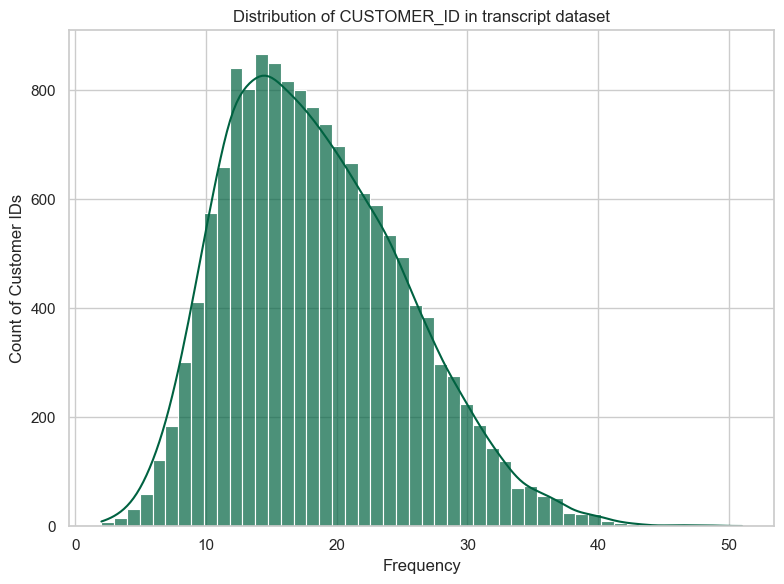

In [ ]:
#find frequency of each customer ids in the transcript dataframe
plt.figure(figsize=(8,6))
sns.histplot(data=customer_based_df['customer_frequency'], bins=50, alpha=0.7, color="#006241",  kde=True)
plt.title('Distribution of CUSTOMER_ID in transcript dataset')
plt.xlabel('Frequency')
plt.ylabel('Count of Customer IDs')
plt.tight_layout()
plt.show()

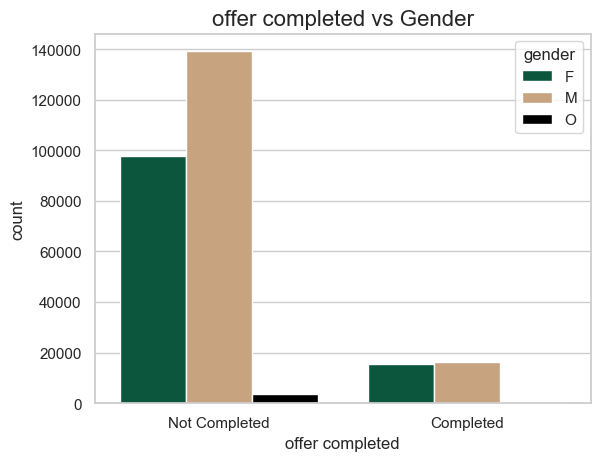

In [ ]:
sns.countplot(data = merged_df, x = 'offer completed', hue = 'gender', palette=starbucks_pal_dark)
plt.title('offer completed vs Gender', fontsize = 16)
plt.xticks([0,1], labels=['Not Completed', 'Completed'])
plt.show()

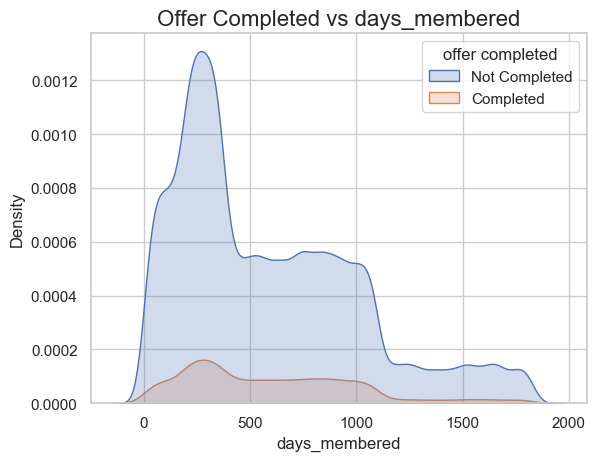

In [ ]:
ax = sns.kdeplot(data=merged_df, x='days_membered', hue='offer completed', fill=True)
plt.title('Offer Completed vs days_membered', fontsize=16)

# 범례 라벨 변경
new_labels = ['Not Completed', 'Completed']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('days_membered')
plt.ylabel('Density')
plt.show()


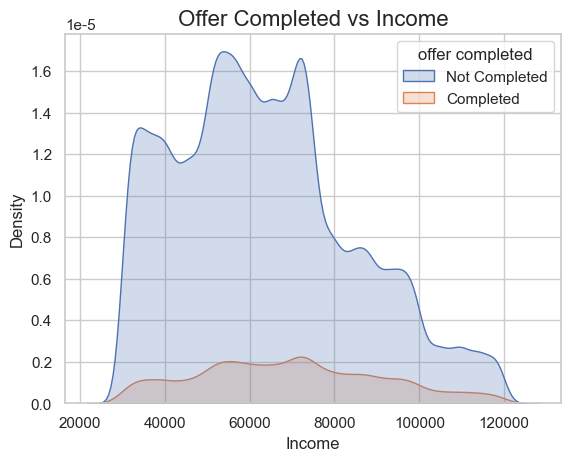

In [ ]:
ax = sns.kdeplot(data=merged_df, x='income', hue='offer completed', fill=True)
plt.title('Offer Completed vs Income', fontsize=16)

# 범례 라벨 변경
new_labels = ['Not Completed', 'Completed']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('Income')
plt.ylabel('Density')
plt.show()


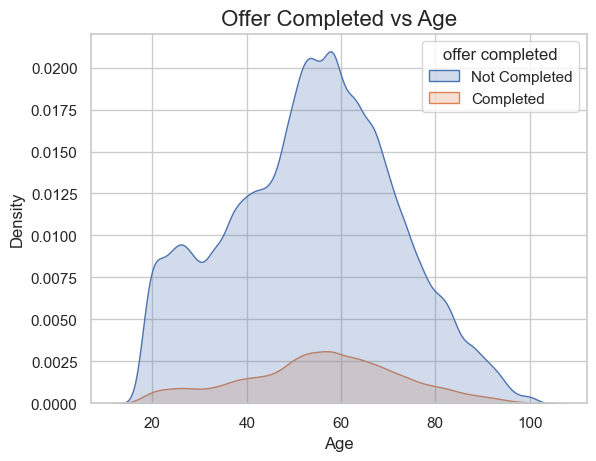

In [ ]:
ax = sns.kdeplot(data=merged_df, x='age', hue='offer completed', fill=True)
plt.title('Offer Completed vs Age', fontsize=16)

# 범례 라벨 변경
new_labels = ['Not Completed', 'Completed']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('Age')
plt.ylabel('Density')
plt.show()


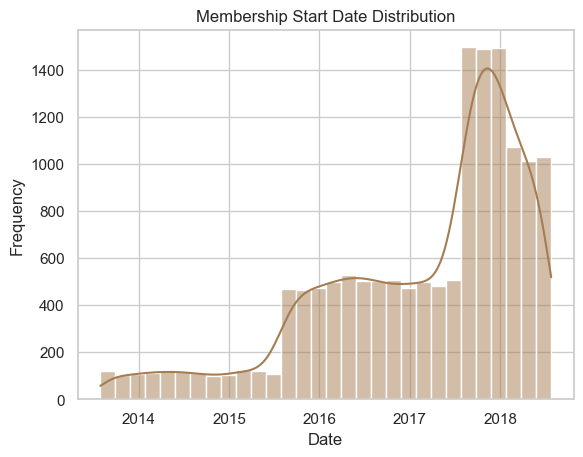

In [ ]:
sns.histplot(data=customer_based_df, x='became_member_on_dt', bins=30, color='#a67c52', kde=True)
plt.title('Membership Start Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

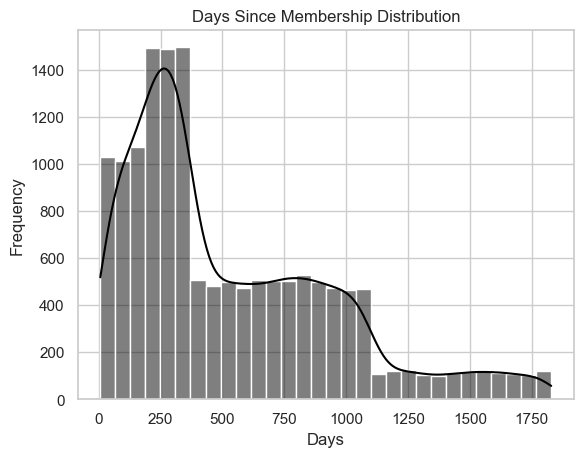

In [ ]:
sns.histplot(data=customer_based_df, x='days_membered', bins=30, kde=True, color='#000000')
plt.title('Days Since Membership Distribution')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()


C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\1696895101.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=income_offer_ratio, x='income', y='offer_completed_ratio', color="#006241", s=100, alpha=0.7, palette='viridis')


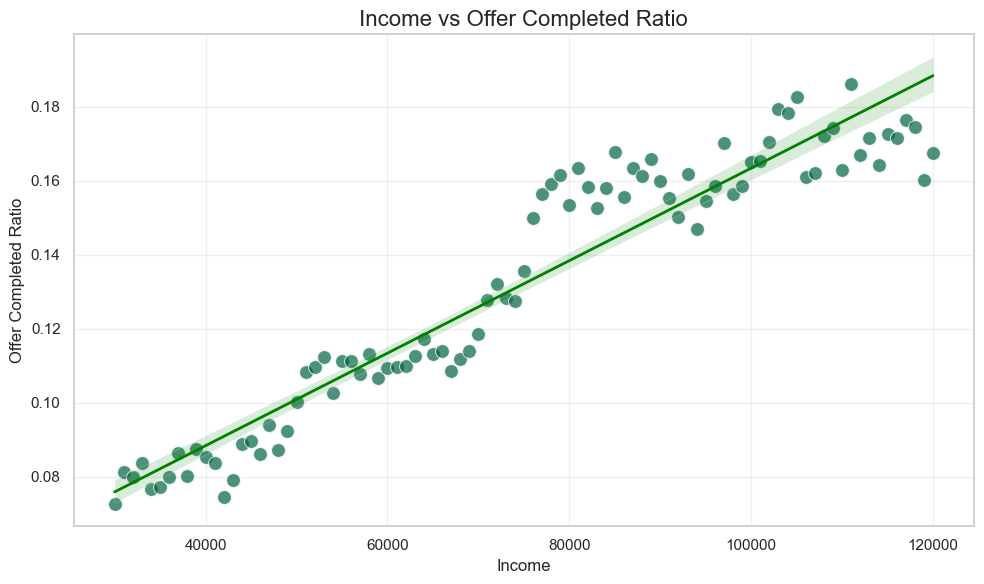

In [ ]:
# 수입과 프로모션 오퍼 완료율 상관 시각화 확인
df = merged_df
income_offer_ratio = (df.groupby('income')['offer completed'].mean().reset_index(name='offer_completed_ratio'))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=income_offer_ratio, x='income', y='offer_completed_ratio', color="#006241", s=100, alpha=0.7, palette='viridis')
sns.regplot(data=income_offer_ratio, x='income', y='offer_completed_ratio', scatter=False, color='green', line_kws={'linewidth': 2})

plt.title("Income vs Offer Completed Ratio", fontsize=16)
plt.xlabel("Income", fontsize=12)
plt.ylabel("Offer Completed Ratio", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

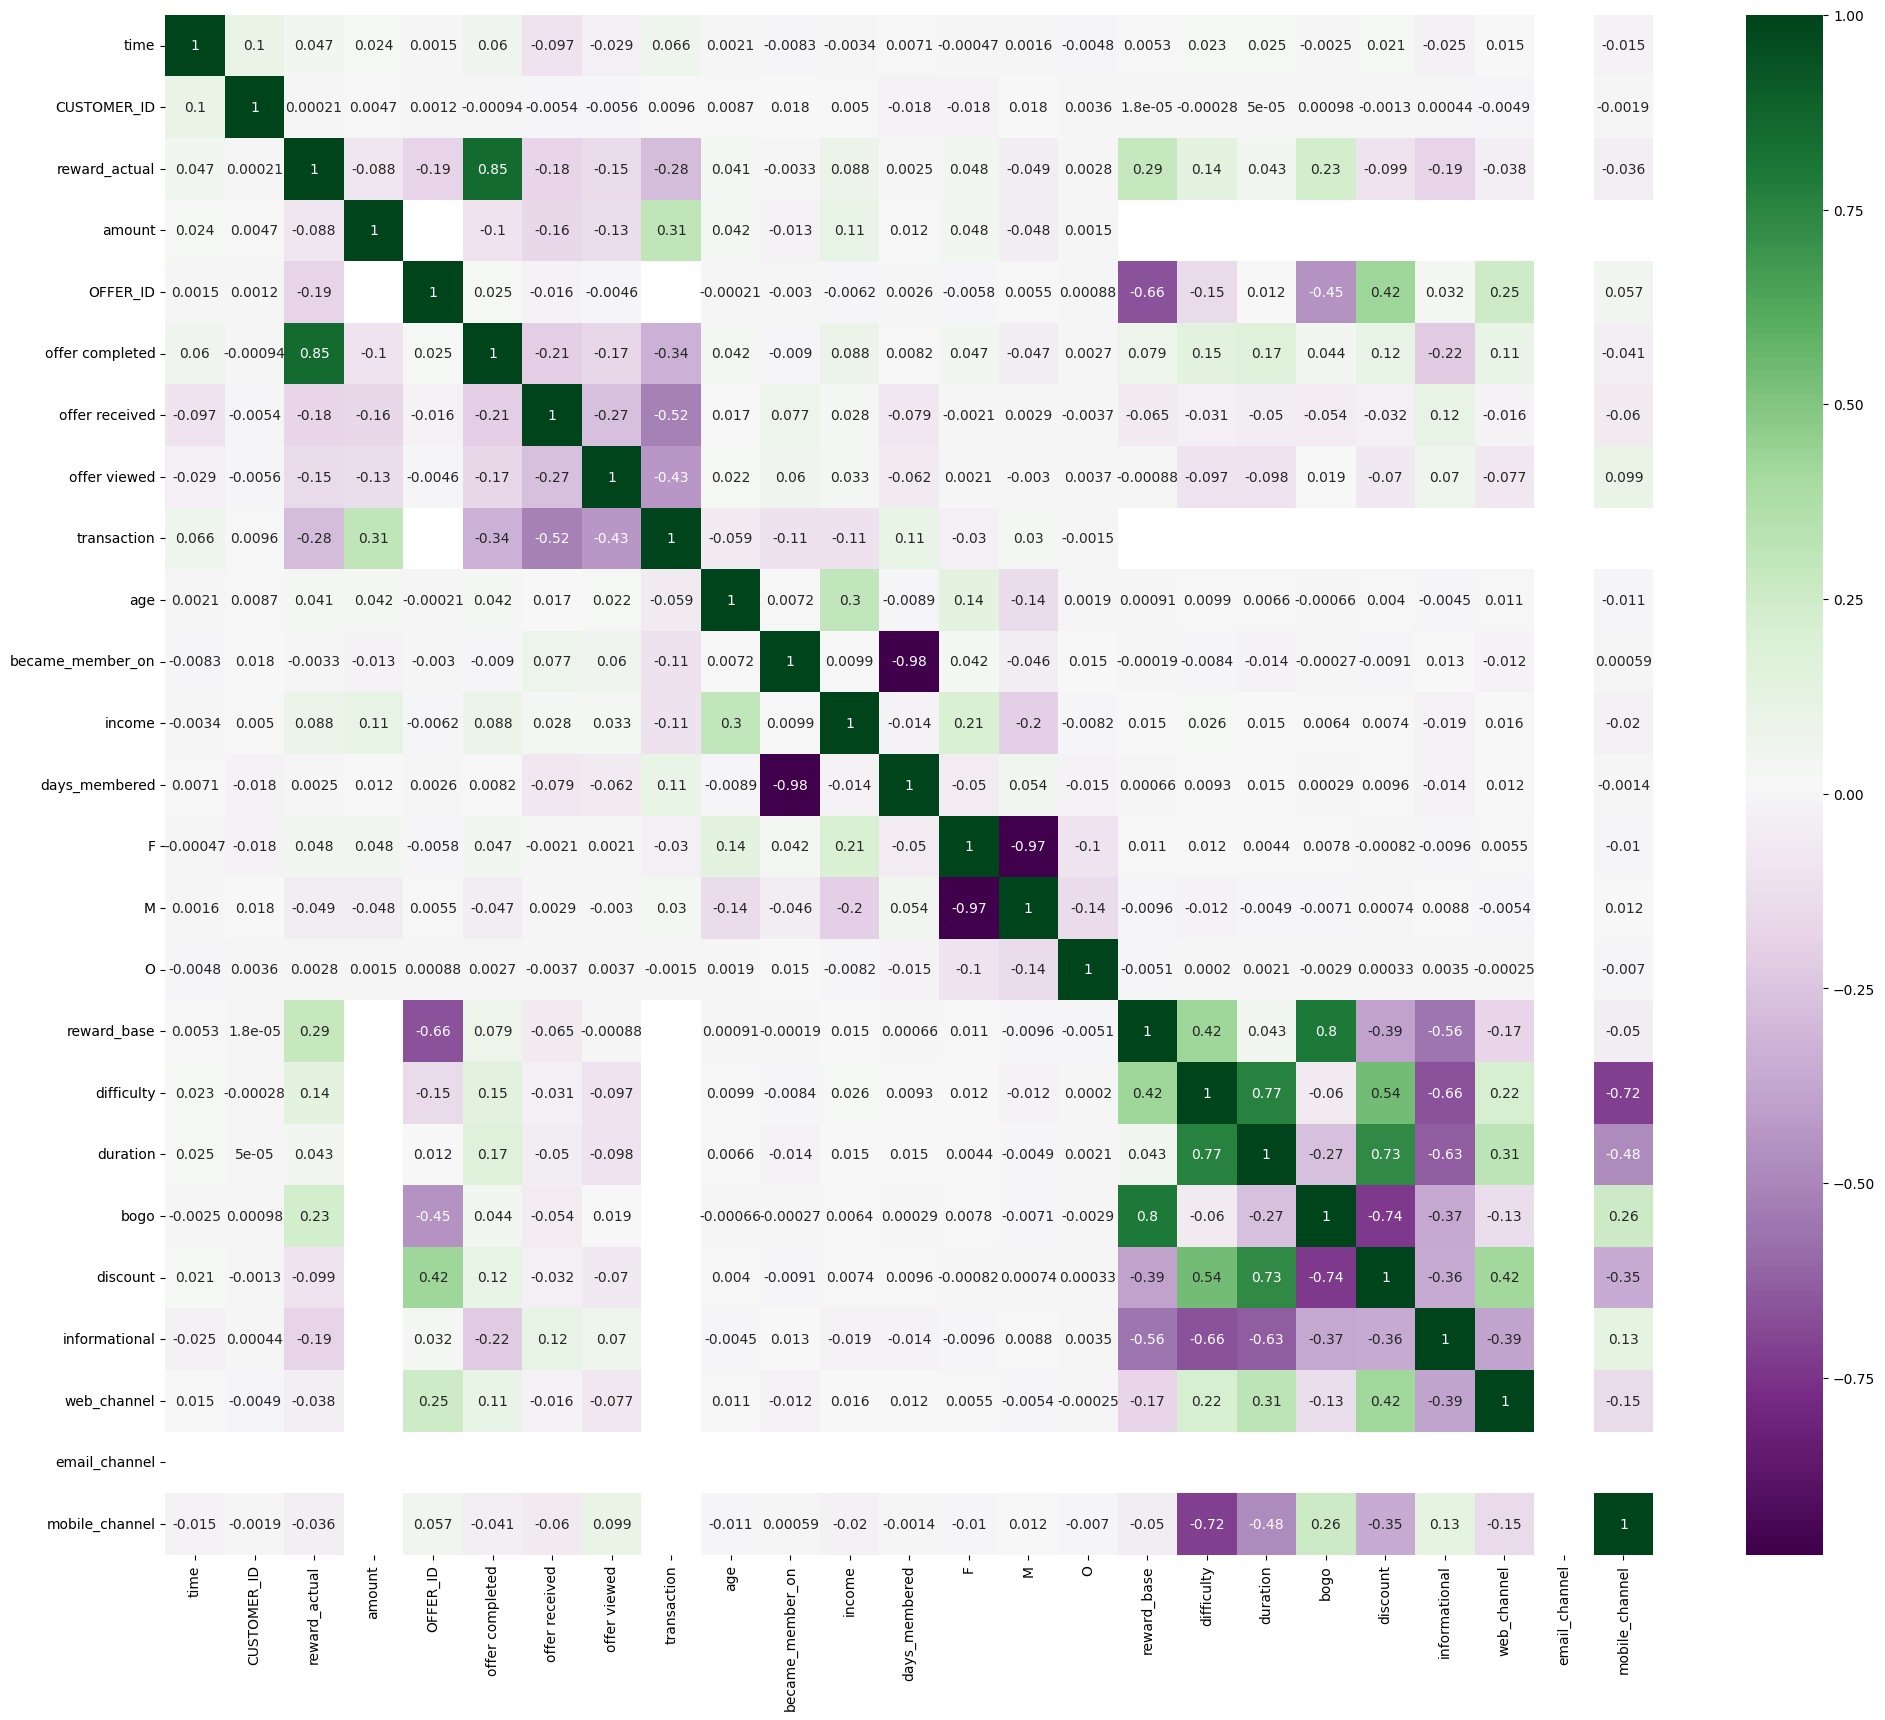

In [ ]:
# merged_df 의 모든 3개 데이터에 숫자형 컬럼들 상관을 쭉 확인 (중간에 ID 값 등은 제외하고 봐야됨)
sns.reset_defaults()
plt.rcdefaults()
plt.style.use('default')
plt.figure(figsize=(24,20))

sample_data = merged_df.select_dtypes(include=["number"])

#compute correlation
corr_matrix = sample_data.corr()
corr_matrix

#annot=True return the correlation values
sns.heatmap(corr_matrix, cmap="PRGn", annot=True)
plt.show()

C:\Users\miseu\AppData\Local\Temp\ipykernel_29844\4164334188.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_based_df, x='event_transaction_cnt', y='age', palette="coolwarm")


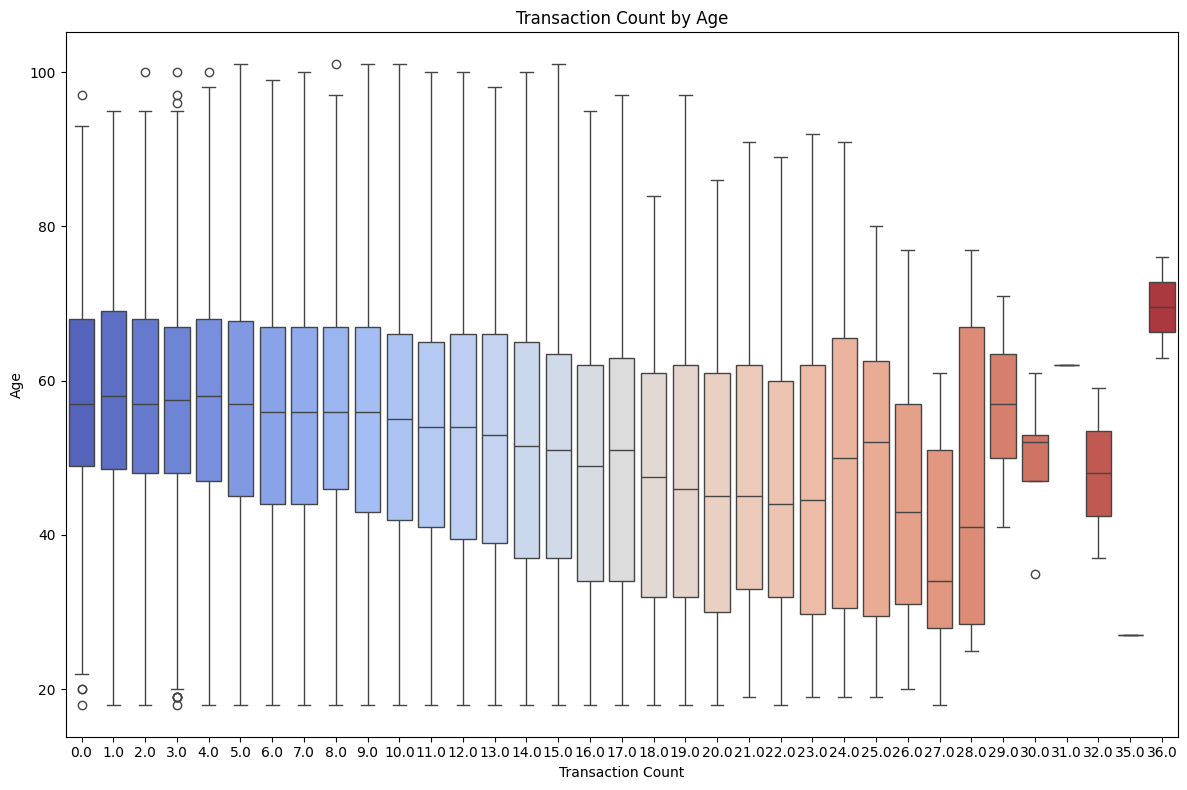

In [ ]:
# 나이-이벤트
plt.figure(figsize=(12,8))
sns.boxplot(data=customer_based_df, x='event_transaction_cnt', y='age', palette="coolwarm")
plt.title('Transaction Count by Age')
plt.xlabel('Transaction Count')
plt.ylabel('Age')
plt.tight_layout()
plt.show()


c:\Users\miseu\anaconda3\envs\datacamp\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\miseu\anaconda3\envs\datacamp\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\miseu\anaconda3\envs\datacamp\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\miseu\anaconda3\envs\datacamp\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\miseu\anaconda3\envs\datacamp\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\miseu\anaconda3\envs\datacamp\L

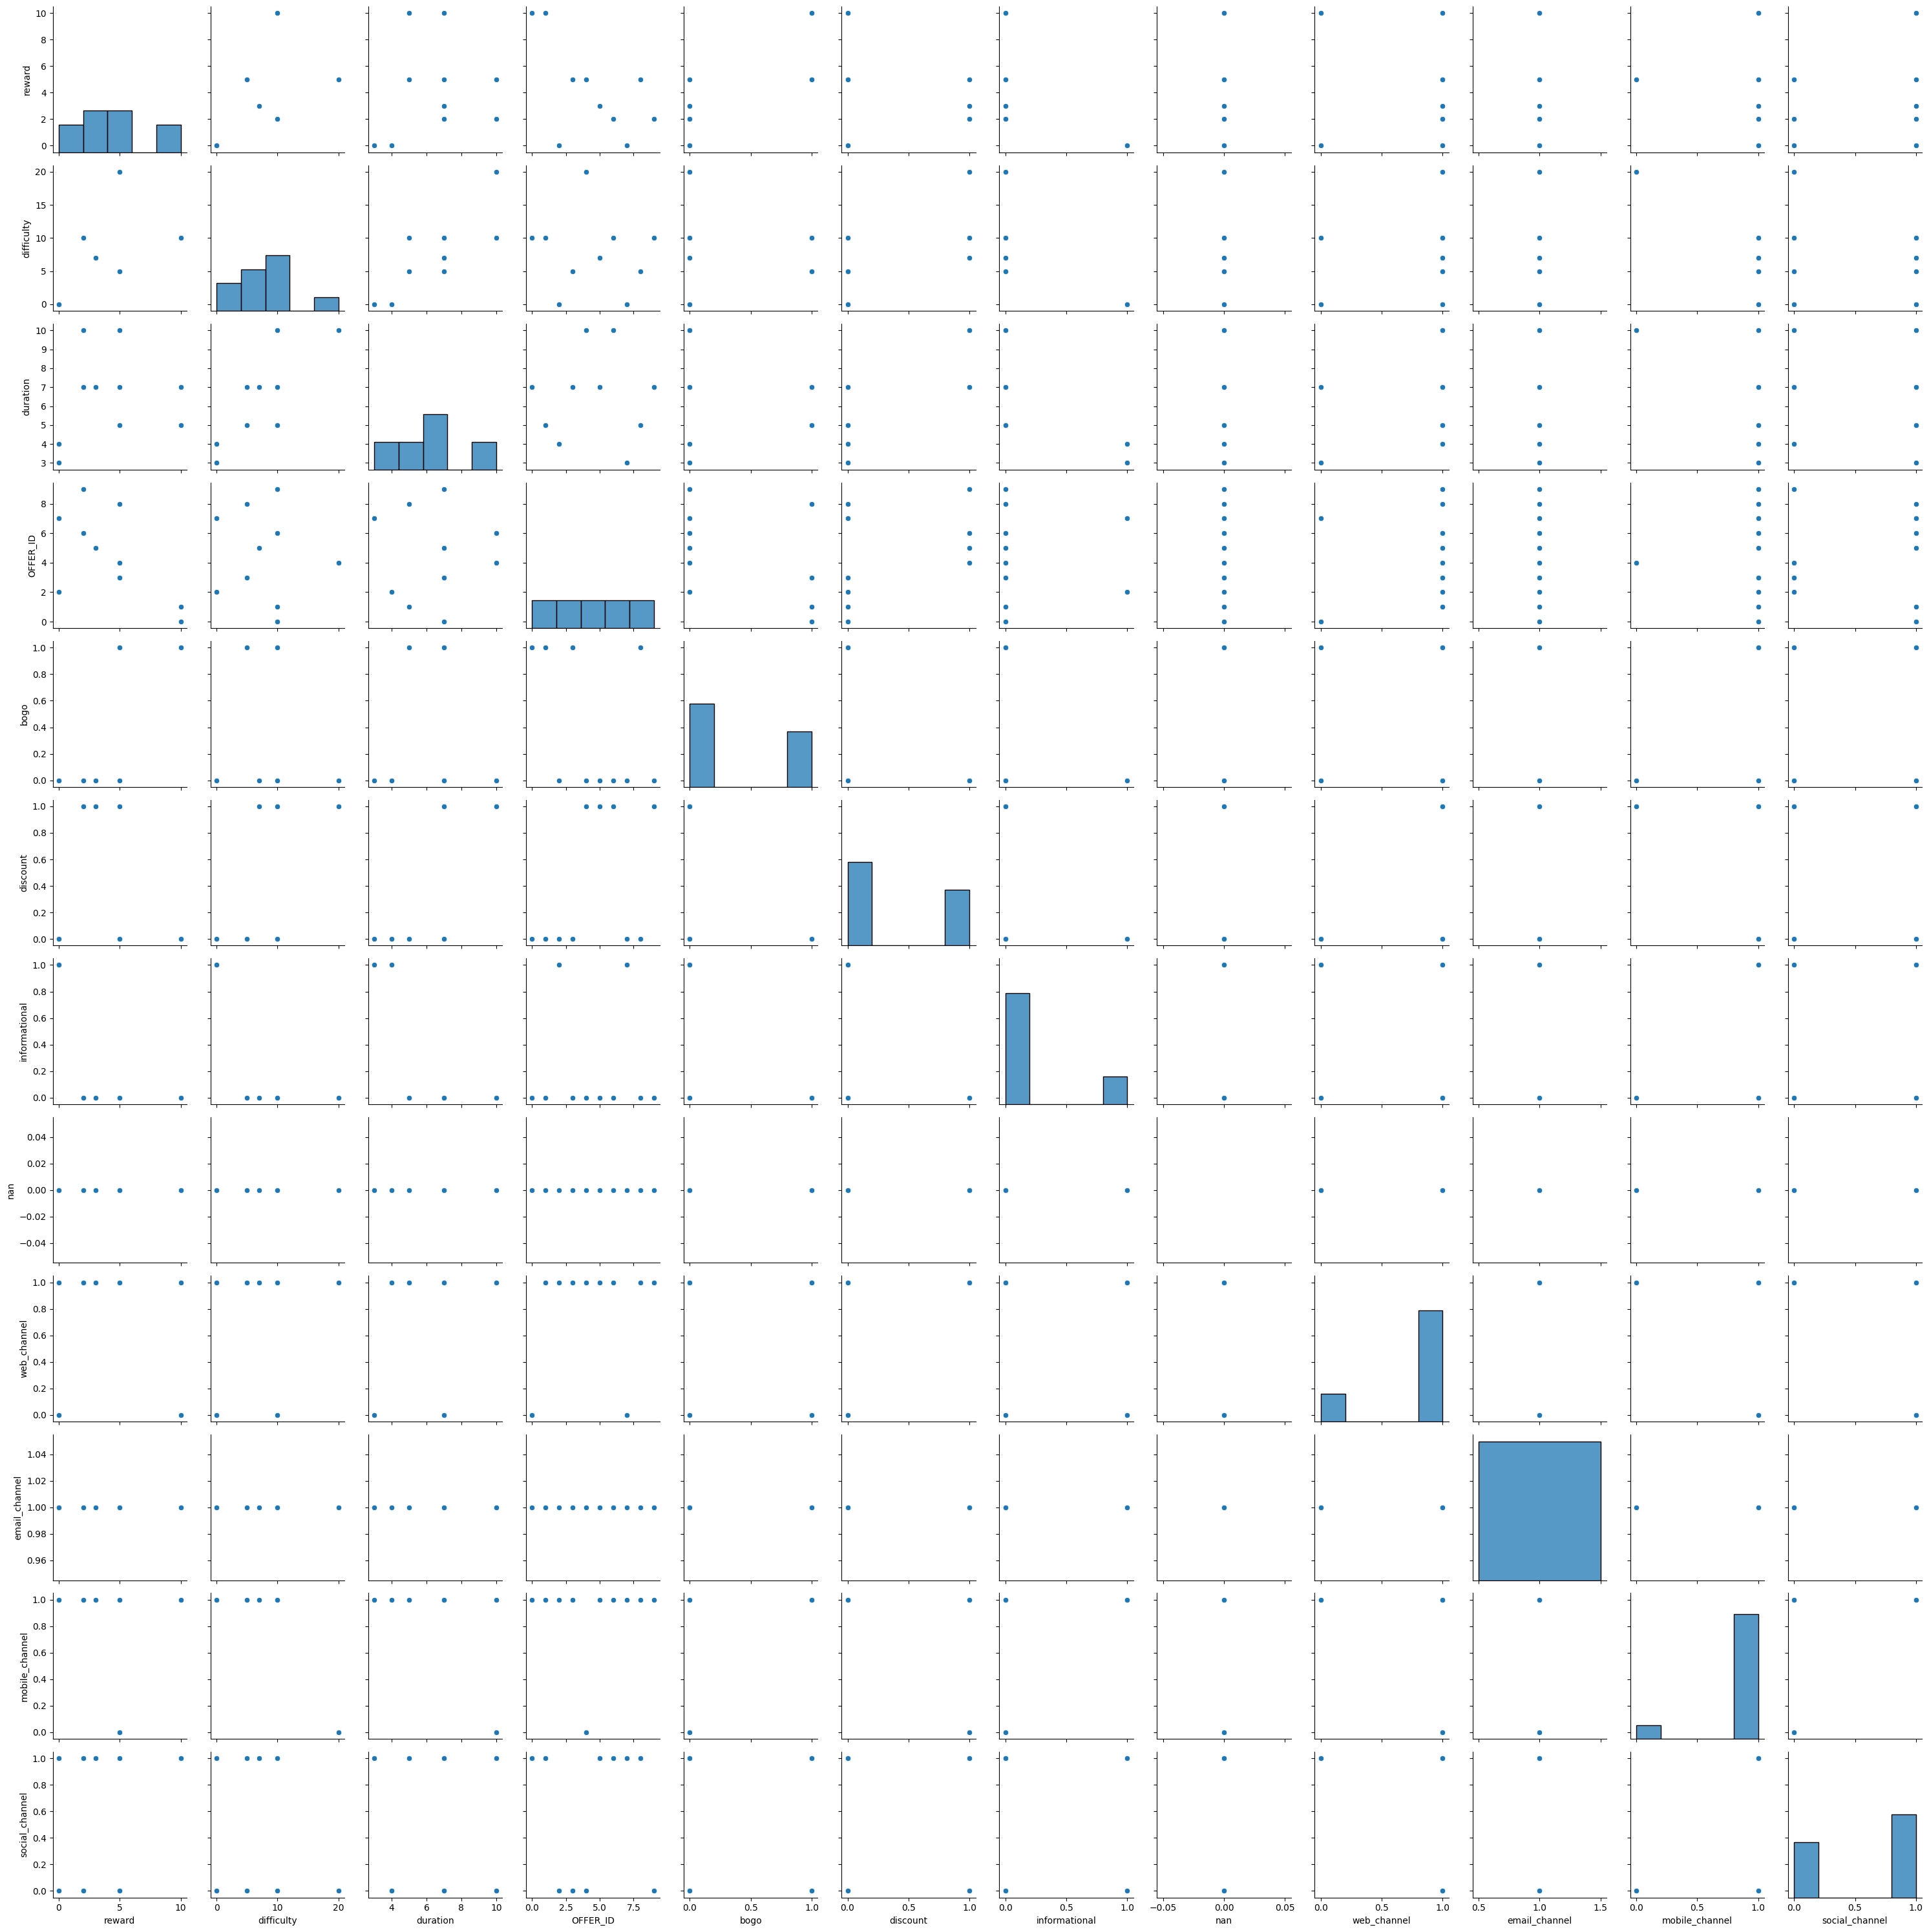

In [ ]:
# 데이터 전반 pairplot (지금 출력된 건 포트폴리오 데이터 기준)
plt.close()

df = portfolio_df
g = sns.pairplot(df, palette="coolwarm")
plt.tight_layout()

plt.show()

# 4. 모델링